# 1. Import  libraries

In [1]:
%matplotlib inline

import pandas as pd 
import math
import matplotlib.pyplot as plt 
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
from scipy.stats.stats import spearmanr

# 2. Change the working directory

In [2]:
os.chdir('/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts/')
os.getcwd()

'/Users/neda/Dropbox (PopGen)/tmp/egg_size_method_paper/scripts'

# 3. Functions

In [3]:
#This function computes the intercept&slope from the reference beads, converts TOF to size and appends size to the original data
def compute_append_size(eg_data):
    bead_200 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='200 um Beads')
    bead_430 = pd.read_excel('../data/Drosophila_eggs_OD1_5_1xPBS_26-03-2021/Ref_bead_26-03-2021.xlsx', sheet_name='430 um Beads')
    
    bead_200_flt = bead_200[bead_200['TOF'] > 600]
    bead_430_flt = bead_430[bead_430['TOF'] > 1800]
    
    x = np.array([200]*95+ [430]*96).reshape((-1, 1))
    x.shape
    y = np.array(list(bead_200_flt['TOF'])+list(bead_430_flt['TOF']))
    y.shape
    
    model = LinearRegression().fit(x, y)    
    sl=model.coef_[0]
    intc =  model.intercept_    
    size = (eg_data['TOF'] - intc) / sl
    eg_data['Size'] = size
    return(eg_data)

#this function specifies a polynomial function with 8 orders. 
#Source: https://stackoverflow.com/questions/48469889/how-to-fit-a-polynomial-with-some-of-the-coefficients-constrained
def func(x, a, b, c, d, e, f, g, h, i):
  return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 + g * x ** 6 + h * x ** 7+ i * x ** 8

#This function computes the area under a curve with a a polynomial function with 8 orders fit to it
def compute_area(x,coefs):
    area = sum(coefs[0] + coefs[1]*x + coefs[2]*x**2+ coefs[3]*x**3 + coefs[4]*x**4 +
               coefs[5]*x**5 + coefs[6]*x**6+ coefs[7]*x**7+ coefs[8]*x**8)
    return area
        
#This function extracts information (e.g. Ellipticalness index, EI, W: the highest recorded extinction by Biosorter for an object,
#L: the length of object, i.e. TOF, WL: the ratio of W to L which corresponds to the orientation of the elliptical object)
# The input data for this function are Biosorter output (the summary file and optical density).
def extract_optical_density(bio_data, opt_data):
    all_EI, all_W, all_L, all_WL = [], [], [], []
    #find the matching data in the 2 input files for each object using 'Id'
    for i in bio_data['Id']:
        #Each object has 4 optical density reading (each stored as a column in optical density file, we will 
        #only use the first one which corresponds to Extinction) 
        #remove zero values in the optical density data
        optden_nonzero = opt_data[str(i)][opt_data[str(i)]>0]    
        #if object is small, set all parameters to 0
        if len(optden_nonzero) <= 11:
            W, EI, L, WL = max(optden_nonzero), 0, 0,0
            all_EI.append(EI)
            all_W.append(W)
            all_L.append(L)
            all_WL.append(WL)   
        #if object is big compute parameters    
        if len(optden_nonzero) > 11:
            #L: corresponds to the recorded data for TOF
            L = len(optden_nonzero)
            #W: The Maximum recorded Extinction for an object
            W = max(optden_nonzero) - min(optden_nonzero)
            #Compute the Elliptical area using the estimated L and W. Note that it is divided by 2 because 
            #we will compare it with the area of an object under the optical density curve which is half an ellipse. 
            EllipArea = (math.pi*W*(L/2))/2
            #fit a curve to the optical density data
            X = np.linspace(0.5, L+0.5, L)
            ry = optden_nonzero - min(optden_nonzero)     
            popt_cons, popt_covar = curve_fit(func, X, ry)
            #compute the area under the optical density file
            Area = compute_area(X, popt_cons)
            #compute Ellipticalness index
            EI = Area/EllipArea  
            WL = W/L
            all_EI.append(EI)
            all_W.append(W)             
            all_L.append(L)
            all_WL.append(WL)
    return(all_EI, all_W, all_L, all_WL)   

#This function computes size, EI, W, L and W/L and append to the original dataset 
def compute_size_EI_WL(bio_data,opt_data):
    #remove columns that are not needed
    bio_data.drop(['Plate','Source well', 'Clog','PC Extinction',
                  'PC BFP','PC GFP','PC dsRED', 'Unnamed: 26'], inplace=True, axis=1)
    
    bio_data_sz = compute_append_size(bio_data)
    bio_data_sz['EI'],bio_data_sz['W'], bio_data_sz['L'], bio_data_sz['W/L']= extract_optical_density(bio_data_sz, opt_data)       
    return bio_data_sz

#This function keeps the sorted objects, and then merges biosorter and manual measurements, 
#it also compute difference between manual and biosorter size
def merge_bio_sorter_manual(bio_data_sz,man_data):
    bio_data_sz_sz_srt = bio_data_sz[bio_data_sz['Sorted status'] == 6]
    bio_data_sz_sz_srt['plate_well'] = bio_data_sz_sz_srt['Row']+'_'+bio_data_sz_sz_srt['Column'].astype(int).astype(str)
    data_bio_man = pd.merge(bio_data_sz_sz_srt,man_data, how="inner", on= ['plate_well'])    
    data_bio_man['diff'] = data_bio_man['length(µm)'] - data_bio_man['Size']
    return data_bio_man


# 4. Comparison of Biosorter size estimates and manual measurements 

## 4.1 Input files 

### The manual measurements and the corresponding Biosorter runs have been performed on 2 days. For each day we will have biosorter data and manual measurements (done manually in ImageJ).

## Biosorter summary files

### The first file is Biosorter output that contains information about TOF, Extinction and fluorescence absorbance (summary file). We remove rows at the end of the file about specifications of each run that are not needed.

In [4]:
#12/04/2022 measurement
R12_1_bio = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_12-04-2022/R12.txt')
R12_1_bio=R12_1_bio.drop(R12_1_bio.index[3120:])

#20/06/2022 measurement
R12_2_bio = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test4_sort_R12.txt')
R12_2_bio=R12_2_bio.drop(R12_2_bio.index[1506:])

## Optical density files

### The second file contains the optical density data. This file contains columns that correspond to each object in the summary file. Each object has 4 corresponding columns. We only need the first one which corresponds to Extinction, the other 3 correspond to 3 fluorescence laser. We remove the columns that are not needed.

In [5]:
#12/04/2022 measurement
R12_1_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_12-04-2022/R12_prf.txt')

#20/06/2022 measurement
R12_2_opt = pd.read_table('../data/Drosophila_eggs_OD1_5_1xPBS_20-06-2022/test4_sort_R12_prf.txt')

## Manual measurements

In [6]:
#12/04/2022 measurement
R12_1_man = pd.read_excel(r'../claudia/manual_egg_size_12042022.xlsx', sheet_name='R12_length')

#20/06/2022 measurement
R12_2_man = pd.read_excel(r'../claudia/manual_egg_size_20062022.xlsx', sheet_name='R12_length')

## 4.2 Feature extraction

### We compute size, Ellipticalness index, and W/L ratio.

In [7]:
R12_1_bio_sz = compute_size_EI_WL(R12_1_bio,R12_1_opt)
R12_2_bio_sz = compute_size_EI_WL(R12_2_bio,R12_2_opt)

### we merge biosorter and manual measurements

In [8]:
R12_1_bio_man = merge_bio_sorter_manual(R12_1_bio_sz,R12_1_man)
R12_2_bio_man = merge_bio_sorter_manual(R12_2_bio_sz,R12_2_man)

<ipython-input-3-be41fdd97005>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_data_sz_sz_srt['plate_well'] = bio_data_sz_sz_srt['Row']+'_'+bio_data_sz_sz_srt['Column'].astype(int).astype(str)
<ipython-input-3-be41fdd97005>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_data_sz_sz_srt['plate_well'] = bio_data_sz_sz_srt['Row']+'_'+bio_data_sz_sz_srt['Column'].astype(int).astype(str)


### We pool measurements done on 2 days.

In [9]:
all_bio_man = pd.concat([R12_1_bio_man,R12_2_bio_man])

In [10]:
all_bio_man.head()

,Id,Time,Row,Column,Sorted status,In Regions,TOF,Extinction,BFP,GFP,...,Size,EI,W,L,W/L,plate_well,id,gate,length(µm),diff
0,466,15246661,A,1.0,6.0,1.000000e+18,1960.0,894.0,175.0,1458.0,...,412.717692,0.992048,42744,245,174.465306,A_1,1,12,527.200,114.482308
1,499,15247123,A,2.0,6.0,1.000000e+18,1944.0,794.0,206.0,1408.0,...,410.024345,0.848459,43804,243,180.263374,A_2,2,12,531.078,121.053655
2,577,15248057,A,3.0,6.0,1.000000e+18,2056.0,619.0,308.0,1413.0,...,428.877772,0.717282,36792,257,143.159533,A_3,3,12,534.644,105.766228
3,818,15251122,A,4.0,6.0,1.000000e+18,2096.0,661.0,384.0,1370.0,...,435.611139,0.733623,39552,262,150.961832,A_4,4,12,500.061,64.449861
4,974,15252999,A,5.0,6.0,1.000000e+18,1984.0,808.0,356.0,1455.0,...,416.757712,0.910245,41504,248,167.354839,A_5,5,12,523.725,106.967288


## We visualize the extracted features

### First have a look at correlation of difference between Biosorter and manual measurement and W/L ratio (a proxy for object orientation)

SpearmanrResult(correlation=0.3401507328576052, pvalue=0.0009082335516817418)

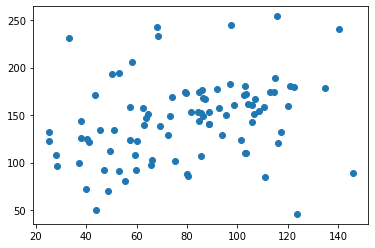

In [11]:
plt.scatter(all_bio_man['diff'], all_bio_man['W/L'])
spearmanr(all_bio_man['diff'], all_bio_man['W/L'])

### Then we look at the correlation between manual measurement and W/L ratio (a proxy for object orientation)

SpearmanrResult(correlation=-0.15073285760522787, pvalue=0.15150958614693455)

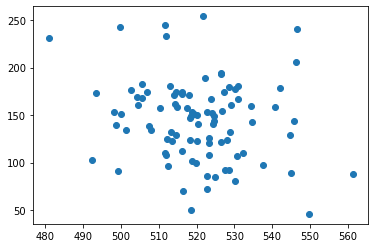

In [12]:
plt.scatter(all_bio_man['length(µm)'], all_bio_man['W/L'])
spearmanr(all_bio_man['length(µm)'], all_bio_man['W/L'])

### And finally, we look at the correlation between Biosorter estimated size and W/L ratio (a proxy for object orientation)

SpearmanrResult(correlation=-0.44068152810543443, pvalue=1.1013327924097832e-05)

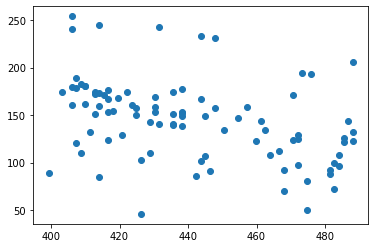

In [13]:
plt.scatter(all_bio_man['Size'], all_bio_man['W/L'])
spearmanr(all_bio_man['Size'], all_bio_man['W/L'])

## The difference between Biosorter and manual measurements are positively correlated with W/L. It means that if the orientation of an egg is not correct the difference between biosorter and manual measurement will be more. Thus, we will sort the data to remove outliers with extreme EI and W/L.

## 4.3 Data filtering

### We filter for the objects with EI and W/L outside median +/- sd/2 and those objects with extreme difference between the two measurements.

In [14]:
med_EI=np.median(all_bio_man['EI'])
std_EI=np.std(all_bio_man['EI'])
all_bio_man_flt1 = all_bio_man[(all_bio_man['EI'] >= med_EI-(std_EI/2)) & (all_bio_man['EI'] <= med_EI+(std_EI/2))]

med_WL=np.median(all_bio_man['W/L'])
std_WL=np.std(all_bio_man['W/L'])
all_bio_man_flt2 = all_bio_man_flt1[(all_bio_man_flt1['W/L'] <= med_WL+(std_WL/2))]

all_bio_man_flt3 = all_bio_man[(all_bio_man['diff'] <= 85)]

## We visualize the correlation between Biosorter and manual measurements.

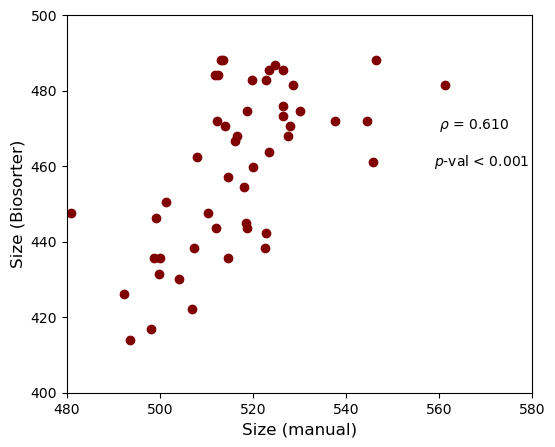

In [15]:
fig , ax = plt.subplots(sharex=True, sharey=True,figsize=(6,5),dpi=100, facecolor='w', edgecolor='k')    
plt.scatter(all_bio_man_flt3['length(µm)'], all_bio_man_flt3['Size'],marker='o', color='maroon')
plt.xlim(480,580)
plt.ylim(400,500)
plt.annotate(r'$\rho$ = %.3f'%(np.round(spearmanr(all_bio_man_flt3['length(µm)'], all_bio_man_flt3['Size'])[0],3)), xy=(560,470),fontsize=10)
plt.annotate('$\it{p}$-val < 0.001', xy=(559,460),fontsize=10)
plt.xlabel('Size (manual)', fontsize=12) 
plt.ylabel('Size (Biosorter)', fontsize=12)
plt.savefig('../plots/final_plots/R12_manual_biosorter_size_correlation.png', dpi=100,format='png', bbox_inches = 'tight')
plt.savefig('../plots/final_plots/R12_manual_biosorter_size_correlation.svg', dpi=100,format='svg', bbox_inches = 'tight')
